In [1]:
import pymysql.cursors
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib.ticker as mticker

# Connect to the database
connection = pymysql.connect(host='localhost',
                             user='root',
                             password='root',
                             db='tv4e',
                             charset='latin1',
                             cursorclass=pymysql.cursors.DictCursor)
connection

In [2]:
query = "SELECT * FROM majordomo_rating WHERE NOT ((watched_type = 'forced' OR user_id IN (1, 2, 3, 21, 9)))"
df_ratings = pd.read_sql(query, connection)

df_ratings.set_index('id', inplace=True)
df_ratings = df_ratings[df_ratings.watched_type != 'forced']

df_ratings.head()

,watch_time,date_creation,watched_type,rating_implicit,rating_explicit,overall_rating_value,user_id,video_id
id,,,,,,,,
21313,100,2018-01-20 22:07:39,injected,1.0,1.0,1.0,4,5363
21314,100,2018-01-20 13:44:41,injected,1.0,NaN,0.5,4,5385
21315,100,2018-01-20 21:37:39,injected,1.0,NaN,0.5,4,5393
21316,100,2018-01-20 17:44:46,injected,1.0,NaN,0.5,4,5423
21317,100,2018-01-20 15:14:35,injected,1.0,0.0,0.3,4,5427


In [3]:
df_ratings.describe()

,watch_time,rating_implicit,rating_explicit,overall_rating_value,user_id,video_id
count,275.000000,275.000000,142.000000,275.000000,275.000000,275.000000
mean,94.581818,0.945818,0.239437,0.441353,28.836364,5721.109091
std,20.026343,0.200263,0.570300,0.370157,10.976358,260.797463
min,1.000000,0.010000,-1.000000,-1.000000,4.000000,5363.000000
25%,100.000000,1.000000,0.000000,0.300000,24.000000,5463.000000
50%,100.000000,1.000000,0.000000,0.500000,33.000000,5775.000000
75%,100.000000,1.000000,1.000000,0.500000,37.000000,5843.000000
max,100.000000,1.000000,1.000000,1.000000,42.000000,6357.000000


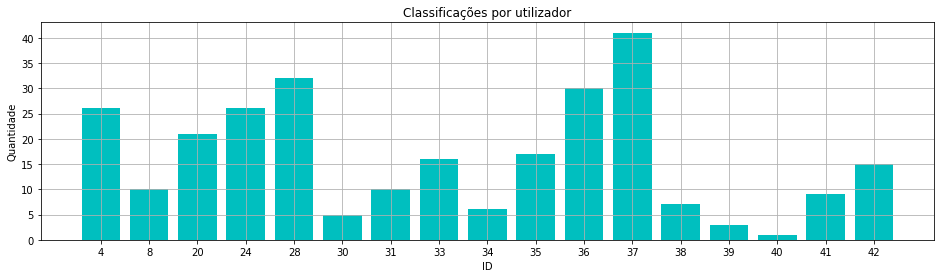

Número de classificações: 275
Número de utilizadores: 17
Média de vídeos vistos por utilizador: 16


In [4]:
# Grouping ratings by user
df_ratings_by_user = df_ratings.groupby(['user_id']).size().reset_index(name='counts')
id = df_ratings_by_user.user_id.unique().astype(str)

plt.clf()
fig = plt.figure(figsize=(16,4))

plt.title('Classificações por utilizador')
plt.bar(range(len(id)), df_ratings_by_user.counts, color='c', width=0.8)
plt.ylabel('Quantidade')
plt.xlabel('ID')

plt.xticks(range(len(id)),id)

plt.grid(True)
plt.show()

number_of_ratings = df_ratings.shape[0]
number_of_users = len(id)
print("Número de classificações: {}".format(number_of_ratings))
print("Número de utilizadores: {}".format(number_of_users))
print("Média de vídeos vistos por utilizador: {0:.0f}".format(number_of_ratings/number_of_users))

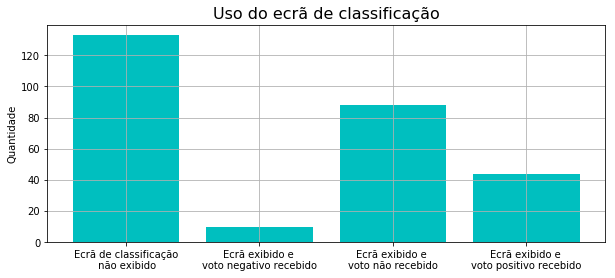

In [5]:
# Checking ratings distribution
df_ratings_distribution = df_ratings.fillna(-2) # using -2 to represent the scenario where no rating screen was shown
df_ratings_distribution = df_ratings_distribution.groupby(['rating_explicit']).size().reset_index(name='counts')


plt.clf()
fig = plt.figure(figsize=(10,4))
plt.title('Uso do ecrã de classificação', fontsize=16)
plt.bar(range(len(df_ratings_distribution.rating_explicit)), df_ratings_distribution.counts, color='c', width=0.8)
plt.ylabel('Quantidade')


labels = ['Ecrã de classificação\n não exibido',
          'Ecrã exibido e \nvoto negativo recebido', 
          'Ecrã exibido e \nvoto não recebido',
          'Ecrã exibido e \nvoto positivo recebido']

plt.xticks(range(len(df_ratings_distribution.rating_explicit)), labels)

plt.grid(True)
plt.show()

In [6]:
# Checking algoritmh precision

df_precision = df_ratings.dropna()

positive_votes = df_precision[df_precision['rating_explicit'] ==  1].shape[0]
negative_votes = df_precision[df_precision['rating_explicit'] == -1].shape[0]
neutral_votes = df_precision[df_precision['rating_explicit'] == 0].shape[0]
all_votes = df_precision.shape[0]

precision = positive_votes/(positive_votes+negative_votes)
print("Precisão do algoritmo: {0:.2f}%". format(precision*100))
print("Votos positivos: {0}". format(positive_votes))
print("Votos negativos: {0}". format(negative_votes))
print("Votos neutros: {0}". format(neutral_votes))

Precisão do algoritmo: 81.48%
Votos positivos: 44
Votos negativos: 10
Votos neutros: 88


In [7]:
# Checking features correlations
# Use dummies of watched type to check corr between ratings and types
df_ratings.corr()

,watch_time,rating_implicit,rating_explicit,overall_rating_value,user_id,video_id
watch_time,1.000000,1.000000,0.059476,0.243849,0.040249,-0.028498
rating_implicit,1.000000,1.000000,0.059476,0.243849,0.040249,-0.028498
rating_explicit,0.059476,0.059476,1.000000,0.967486,-0.373288,-0.322573
overall_rating_value,0.243849,0.243849,0.967486,1.000000,-0.225298,-0.233651
user_id,0.040249,0.040249,-0.373288,-0.225298,1.000000,0.725364
video_id,-0.028498,-0.028498,-0.322573,-0.233651,0.725364,1.000000


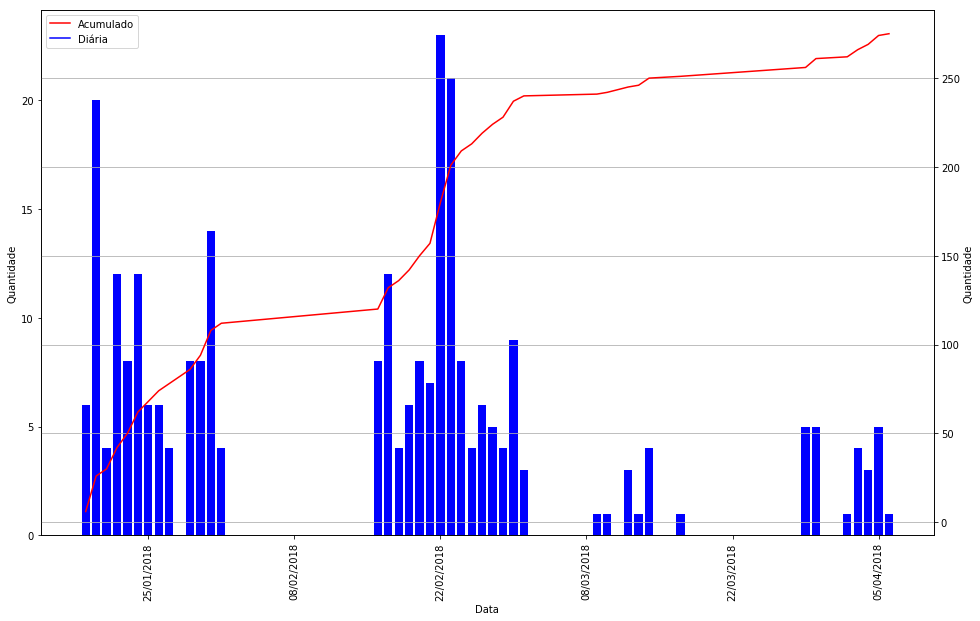

In [8]:
from collections import Counter
import datetime as dt
import matplotlib.dates as mdates

df_ratings['TimeStamp'] = pd.to_datetime(df_ratings['date_creation']).dt.strftime('%m/%d/%Y')
d = Counter(df_ratings['TimeStamp'])
df = pd.DataFrame(list(d.items()), columns=['Date', 'Count'])
df = df.set_index('Date').sort_index()
df.index = pd.to_datetime(df.index)

plt.clf()
fig = plt.figure(figsize=(16, 10))
ax1 = plt.subplot2grid((1,1), (0,0))
ax2 = ax1.twinx()

ax1.bar(df.index, df.Count, color='b')
ax2.plot(df.index, df.Count.cumsum(), color='r', label='Acumulado')
ax2.plot([], [], color='b', label='Diária')
ax1.set_ylabel('Quantidade')
ax2.set_ylabel('Quantidade')
ax1.set_xlabel('Data')

for label in ax1.xaxis.get_ticklabels():
    label.set_rotation(90)

ax1.xaxis.set_major_formatter(mdates.DateFormatter("%d/%m/%Y"))
ax1.xaxis.set_minor_formatter(mdates.DateFormatter("%d/%m/%Y"))

fig.subplots_adjust(bottom=0.15)
ax2.legend(loc='best')

plt.grid(True)
plt.show()



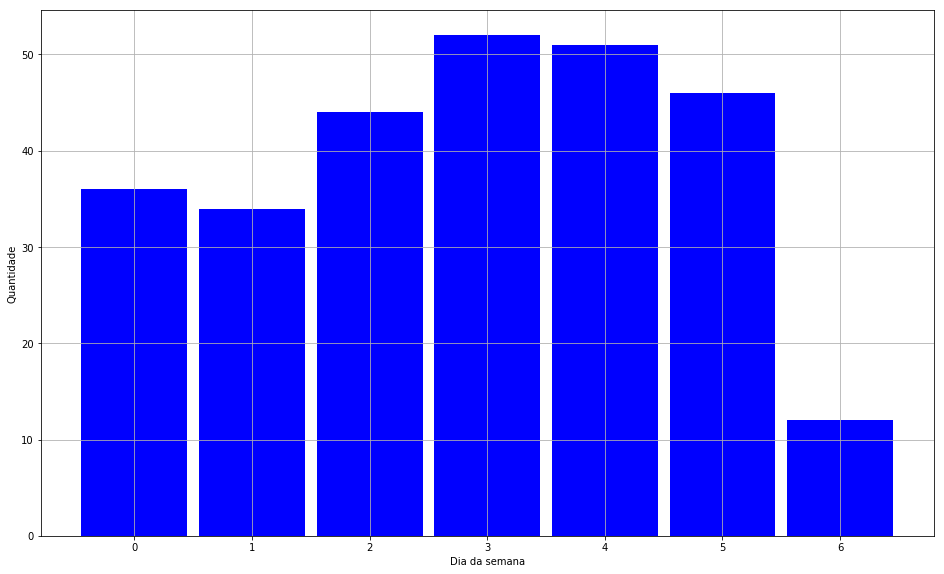

In [9]:
from collections import Counter
import datetime as dt
import matplotlib.dates as mdates

weekdays_keys = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekdays_values = ['Segunda', 'Terça', 'Quarta', 'Quinta', 'Sexta', 'Sábado', 'Domingo']
weekdays_dict = dict(zip(weekdays_keys, weekdays_values))

df_ratings['weekday_name'] = pd.to_datetime(df_ratings['date_creation']).dt.weekday_name
d = Counter(df_ratings['weekday_name'])

df = pd.DataFrame(list(d.items()), columns=['weekday_name', 'count'])
def f(row):
    return weekdays_keys.index(row['weekday_name'])
df['weekday'] = df.apply(f, axis=1)

df['weekday_name'].replace(weekdays_dict, inplace=True)
df = df.set_index('weekday').sort_index()

plt.clf()
fig = plt.figure(figsize=(16, 10))
ax1 = plt.subplot2grid((1,1), (0,0))

ax1.bar(df.index, df['count'], color='b', width=0.9)
ax1.set_ylabel('Quantidade')
ax1.set_xlabel('Dia da semana')

fig.subplots_adjust(bottom=0.15)
ax2.legend(loc='best')

plt.grid(True)
plt.show()

In [10]:
# df_ratings
df = pd.DataFrame(df_ratings[['watched_type', 'rating_explicit', 'rating_implicit']])
df = pd.get_dummies(df)
# df_corr = df_corr[df_corr.rating_explicit != 0]

injetados_positivos   = df[(df.rating_explicit == 1)     & (df.watched_type_injected == 1)].shape[0]
injetados_negativos   = df[(df.rating_explicit == -1)    & (df.watched_type_injected == 1)].shape[0]
injetados_neutros     = df[(df.rating_explicit == 0)     & (df.watched_type_injected == 1)].shape[0]
injetados_nulos       = df[pd.isnull(df.rating_explicit) & (df.watched_type_injected == 1)].shape[0]
injetados_total       = df[(df.watched_type_injected == 1)].shape[0]
notificados_positivos = df[(df.rating_explicit == 1)     & (df.watched_type_notified == 1)].shape[0]
notificados_negativos = df[(df.rating_explicit == -1)    & (df.watched_type_notified == 1)].shape[0]
notificados_neutros   = df[(df.rating_explicit == 0)     & (df.watched_type_notified == 1)].shape[0]
notificados_nulos     = df[pd.isnull(df.rating_explicit) & (df.watched_type_notified == 1)].shape[0]
notificados_total     = df[(df.watched_type_notified == 1)].shape[0]
print("injetados_positivos:   "+ str(injetados_positivos))
print("injetados_negativos:   "+ str(injetados_negativos))
print("injetados_neutros:     "+ str(injetados_neutros))
print("injetados_nulos:       "+ str(injetados_nulos))
print("injetados_total:       "+ str(injetados_total))
print("notificados_positivos: "+ str(notificados_positivos))
print("notificados_negativos: "+ str(notificados_negativos))
print("notificados_neutros:   "+ str(notificados_neutros))
print("notificados_nulos:     "+ str(notificados_nulos))
print("notificados_total:     "+ str(notificados_total))

df.dropna(inplace=True)

df_corr1 = df.corr()
df_corr1 = df_corr1.drop(df_corr1.columns[:2], axis=1)
df_corr1 = df_corr1.drop(df_corr1.index[2:], axis=0)
df_corr1


injetados_positivos:   16
injetados_negativos:   5
injetados_neutros:     76
injetados_nulos:       88
injetados_total:       185
notificados_positivos: 28
notificados_negativos: 5
notificados_neutros:   12
notificados_nulos:     45
notificados_total:     90


,watched_type_injected,watched_type_notified
rating_explicit,-0.325612,0.325612
rating_implicit,0.159704,-0.159704


In [12]:
# df_ratings
df = pd.DataFrame(df_ratings[['date_creation', 'rating_explicit', 'rating_implicit']])
df = pd.get_dummies(df)

weekdays_keys = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

df['weekday'] = pd.to_datetime(df_ratings['date_creation']).dt.weekday

df['weekend'] = df.apply(lambda row: row.weekday >= 5,axis=1)
df['workingday'] = df.apply(lambda row: row.weekday < 5,axis=1)

weekend_positivos    = df[(df.rating_explicit == 1)     & (df.weekend)].shape[0]
weekend_negativos    = df[(df.rating_explicit == -1)    & (df.weekend)].shape[0]
weekend_neutros      = df[(df.rating_explicit == 0)     & (df.weekend)].shape[0]
weekend_nulos        = df[pd.isnull(df.rating_explicit) & (df.weekend)].shape[0]
weekend_total        = df[(df.weekend)].shape[0]
workingday_positivos = df[(df.rating_explicit == 1)     & (df.workingday)].shape[0]
workingday_negativos = df[(df.rating_explicit == -1)    & (df.workingday)].shape[0]
workingday_neutros   = df[(df.rating_explicit == 0)     & (df.workingday)].shape[0]
workingday_nulos     = df[pd.isnull(df.rating_explicit) & (df.workingday)].shape[0]
workingday_total     = df[(df.workingday)].shape[0]

print("workingday_positivos: "+ str(workingday_positivos))
print("workingday_negativos: "+ str(workingday_negativos))
print("workingday_neutros:   "+ str(workingday_neutros))
print("workingday_nulos:     "+ str(workingday_nulos))
print("workingday_total:     "+ str(workingday_total))
print("weekend_positivos:    "+ str(weekend_positivos))
print("weekend_negativos:    "+ str(weekend_negativos))
print("weekend_neutros:      "+ str(weekend_neutros))
print("weekend_nulos:        "+ str(weekend_nulos))
print("weekend_total:        "+ str(weekend_total))

df.dropna(inplace=True)

df_corr2 = df.corr()
df_corr2 = df_corr2.drop(df_corr2.columns[:3], axis=1)
df_corr2 = df_corr2.drop(df_corr2.index[2:], axis=0)
df_corr2


workingday_positivos: 38
workingday_negativos: 6
workingday_neutros:   69
workingday_nulos:     104
workingday_total:     217
weekend_positivos:    6
weekend_negativos:    4
weekend_neutros:      19
weekend_nulos:        29
weekend_total:        58


,weekend,workingday
rating_explicit,-0.151964,0.151964
rating_implicit,0.013888,-0.013888


In [13]:
# df_ratings
df = pd.DataFrame(df_ratings[['date_creation', 'rating_explicit', 'rating_implicit']])
df = pd.get_dummies(df)

weekdays_keys = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

df['hour'] = pd.to_datetime(df_ratings['date_creation']).dt.hour

df['morning']   = df.apply(lambda row: (row.hour >=  4) & (row.hour < 12), axis=1)
df['afternoon'] = df.apply(lambda row: (row.hour >= 12) & (row.hour < 20), axis=1)
df['evening']   = df.apply(lambda row: (row.hour >= 20) | (row.hour < 4 ),  axis=1)

morning_positivos    = df[(df.rating_explicit == 1)     & (df.morning)].shape[0]
morning_negativos    = df[(df.rating_explicit == -1)    & (df.morning)].shape[0]
morning_neutros      = df[(df.rating_explicit == 0)     & (df.morning)].shape[0]
morning_nulos        = df[pd.isnull(df.rating_explicit) & (df.morning)].shape[0]
morning_total        = df[(df.morning)].shape[0]
afternoon_positivos  = df[(df.rating_explicit == 1)     & (df.afternoon)].shape[0]
afternoon_negativos  = df[(df.rating_explicit == -1)    & (df.afternoon)].shape[0]
afternoon_neutros    = df[(df.rating_explicit == 0)     & (df.afternoon)].shape[0]
afternoon_nulos      = df[pd.isnull(df.rating_explicit) & (df.afternoon)].shape[0]
afternoon_total      = df[(df.afternoon)].shape[0]
evening_positivos    = df[(df.rating_explicit == 1)     & (df.evening)].shape[0]
evening_negativos    = df[(df.rating_explicit == -1)    & (df.evening)].shape[0]
evening_neutros      = df[(df.rating_explicit == 0)     & (df.evening)].shape[0]
evening_nulos        = df[pd.isnull(df.rating_explicit) & (df.evening)].shape[0]
evening_total        = df[(df.evening)].shape[0]
print("morning_positivos:     "+ str(morning_positivos))
print("morning_negativos:     "+ str(morning_negativos))
print("morning_neutros:       "+ str(morning_neutros))
print("morning_nulos:         "+ str(morning_nulos))
print("morning_total:         "+ str(morning_total))
print("afternoon_positivos:   "+ str(afternoon_positivos))
print("afternoon_negativos:   "+ str(afternoon_negativos))
print("afternoon_neutros:     "+ str(afternoon_neutros))
print("afternoon_nulos:       "+ str(afternoon_nulos))
print("afternoon_total:       "+ str(afternoon_total))
print("evening_positivos:     "+ str(evening_positivos))
print("evening_negativos:     "+ str(evening_negativos))
print("evening_neutros:       "+ str(evening_neutros))
print("evening_nulos:         "+ str(evening_nulos))
print("evening_total:         "+ str(evening_total))

df.dropna(inplace=True)

df_corr3 = df.corr()
df_corr3 = df_corr3.drop(df_corr3.columns[:3], axis=1)
df_corr3 = df_corr3.drop(df_corr3.index[2:], axis=0)
df_corr3

morning_positivos:     3
morning_negativos:     1
morning_neutros:       20
morning_nulos:         19
morning_total:         43
afternoon_positivos:   22
afternoon_negativos:   1
afternoon_neutros:     31
afternoon_nulos:       61
afternoon_total:       115
evening_positivos:     19
evening_negativos:     8
evening_neutros:       37
evening_nulos:         53
evening_total:         117


,morning,afternoon,evening
rating_explicit,-0.123882,0.206010,-0.107690
rating_implicit,0.026355,-0.127567,0.104612


In [14]:
df_corr = pd.concat([df_corr1,df_corr2,df_corr3], axis=1)
columns={'watched_type_injected': 'Modo Impositivo', 
         'watched_type_notified': 'Modo sugestivo',
         'weekend': 'Fim de semana',
         'workingday': 'Dia de semana',
         'morning': 'Manhã',
         'afternoon': 'Tarde',
         'evening': 'Noite'
        }
index={'rating_explicit': 'Feedback explícito',
       'rating_implicit': 'Feedback implícito'
        }
df_corr.rename(columns=columns, index=index, inplace=True)

df_corr

,Modo Impositivo,Modo sugestivo,Fim de semana,Dia de semana,Manhã,Tarde,Noite
Feedback explícito,-0.325612,0.325612,-0.151964,0.151964,-0.123882,0.206010,-0.107690
Feedback implícito,0.159704,-0.159704,0.013888,-0.013888,0.026355,-0.127567,0.104612
